In [2]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset

In [3]:
class LogZNormCoinDataset(Dataset):
    def __init__(self, csv_path, coin_symbol, input_window, output_window, augmentation_p, augmentation_noise_std, augment_constant_c, augment_scale_s, z_norm_means_csv_path="", z_norm_stds_csv_path=""):
        self.df = pd.read_csv(csv_path)
        
        # first column is open_time, so skip it
        start, end  = {'BTC': (1, 5), 'ETH': (5, 9), 'BNB': (9, 13), 'XRP': (13, 17)}[coin_symbol]
        self.coin_cols = self.df.columns[start: end]

        self.input_window = input_window
        self.output_window = output_window

        self.augmentation_p = augmentation_p
        self.augmentation_noise_std = augmentation_noise_std
        self.augment_constant_c = augment_constant_c
        self.augment_scale_s = augment_scale_s

        self.z_norm_means_df = pd.read_csv(z_norm_means_csv_path)
        self.z_norm_stds_df = pd.read_csv(z_norm_stds_csv_path)

    def __len__(self):
        return len(self.df) - self.input_window - self.output_window + 1

    def __getitem__(self, idx):
        analysis_rows = self.df.iloc[idx : idx + self.input_window]
        prediction_rows = self.df.iloc[idx + self.input_window : idx + self.input_window + self.output_window]

        # first 4 columns are BTC_open/close/low_high, and then same 4 for each ETH, BNB, XRP. Each column is a timestamp
        analysis_matrix = analysis_rows[analysis_rows.columns[1:]].to_numpy()
        prediction_target = prediction_rows[self.coin_cols].to_numpy()

        x,y = analysis_matrix.T, prediction_target.T

        if np.random.rand() < self.augmentation_p:
            x = self.augment(x)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def rescale_to_real_price(self, price):
        means = self.z_norm_means_df[self.coin_cols].to_numpy()
        stds = self.z_norm_stds_df[self.coin_cols].to_numpy()
        
        real_price = np.power(10, price.T * stds + means)        
        
        return real_price.T
    
    def augment(self, x):
        if torch.rand(1) < self.augmentation_p:
            x = x + np.random.normal(scale=self.augmentation_noise_std, size=x.shape)

            # this dict explains the low <= close & open <= high logic for each coin
            clip_rules = {(0,1): (2, 3), (4,5): (6, 7), (8,9): (10, 11), (12,13): (14, 15)}

            for ((open_row, close_row), (low_row, high_row)) in clip_rules.items():
                x[open_row] = np.clip(x[open_row], x[low_row], x[high_row])
                x[close_row] = np.clip(x[close_row], x[low_row], x[high_row])
        if torch.rand(1) < self.augmentation_p:
            x = x + np.random.uniform(-self.augment_constant_c, self.augment_constant_c)
        if torch.rand(1) < self.augmentation_p:
            x = x * (1 + np.random.uniform(-self.augment_scale_s, self.augment_scale_s))

        return x

In [4]:
class LogReturnCoinDataset(Dataset):
    def __init__(self, csv_path, coin_symbol, input_window, output_window, augmentation_p, augmentation_noise_std, augment_constant_c, augment_scale_s, distribution_scale, distribution_clip):
        self.df = pd.read_csv(csv_path)
        self.df[self.df.columns[1:]] = self.df[self.df.columns[1:]] * distribution_scale
        self.df[self.df.columns[1:]] = self.df[self.df.columns[1:]].clip(-distribution_clip, distribution_clip)

        # first column is open_time, so skip it
        start, end  = {'BTC': (1, 5), 'ETH': (5, 9), 'BNB': (9, 13), 'XRP': (13, 17)}[coin_symbol]
        self.coin_cols = self.df.columns[start: end]

        self.input_window = input_window
        self.output_window = output_window

        self.augmentation_p = augmentation_p
        self.augmentation_noise_std = augmentation_noise_std
        self.augment_constant_c = augment_constant_c
        self.augment_scale_s = augment_scale_s
        self.distribution_scale = distribution_scale

    def __len__(self):
        return len(self.df) - self.input_window - self.output_window + 1

    def __getitem__(self, idx):
        analysis_rows = self.df.iloc[idx:idx + self.input_window]
        prediction_rows = self.df.iloc[idx + self.input_window:idx + self.input_window + self.output_window]

        # first 4 columns are BTC_open/close/low_high, and then same 4 for each ETH, BNB, XRP. Each column is a timestamp
        analysis_matrix = analysis_rows[analysis_rows.columns[1:]].to_numpy()
        prediction_target = prediction_rows[self.coin_cols].to_numpy()

        x, y = analysis_matrix.T, prediction_target.T

        if np.random.rand() < self.augmentation_p:
            x = self.augment(x)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def augment(self, x):
        if torch.rand(1) < self.augmentation_p:
            x = x + np.random.normal(scale=self.augmentation_noise_std, size=x.shape)

            # this dict explains the low <= close & open <= high logic for each coin
            clip_rules = {(0,1): (2, 3), (4,5): (6, 7), (8,9): (10, 11), (12,13): (14, 15)}

            for ((open_row, close_row), (low_row, high_row)) in clip_rules.items():
                x[open_row] = np.clip(x[open_row], x[low_row], x[high_row])
                x[close_row] = np.clip(x[close_row], x[low_row], x[high_row])
        if torch.rand(1) < self.augmentation_p:
            x = x + np.random.uniform(-self.augment_constant_c, self.augment_constant_c)
        if torch.rand(1) < self.augmentation_p:
            x = x * (1 + np.random.uniform(-self.augment_scale_s, self.augment_scale_s))

        return x

In [8]:
distribution_clip = 10

In [9]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset_train = LogReturnCoinDataset(csv_path="data/BTC_ETH_BNB_XRP_6h_log_returns_train.csv", coin_symbol="BTC",
                               input_window=28, output_window=8, augmentation_p=0, augmentation_noise_std=0,
                               augment_constant_c=0, augment_scale_s=0, distribution_scale=100, distribution_clip=distribution_clip)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=False, drop_last=False)
dataset_train.df.describe()

,BTC_open,BTC_close,BTC_low,BTC_high,ETH_open,ETH_close,ETH_low,ETH_high,BNB_open,BNB_close,BNB_low,BNB_high,XRP_open,XRP_close,XRP_low,XRP_high
count,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000
mean,0.023030,0.022798,0.027993,0.018301,0.019494,0.019018,0.028902,0.011796,0.041104,0.040928,0.055149,0.032256,-0.007004,-0.008131,0.027460,-0.032588
std,1.662973,1.662875,1.701764,1.550500,2.114210,2.112418,2.169583,1.893699,2.155721,2.154958,2.148738,1.933175,2.331100,2.329815,2.366264,2.215103
min,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,-0.577859,-0.578379,-0.579225,-0.565397,-0.831117,-0.825832,-0.767708,-0.758219,-0.843746,-0.841883,-0.731989,-0.765929,-0.924657,-0.924758,-0.805122,-0.915786
50%,0.021866,0.021390,0.130726,-0.070028,0.021570,0.020912,0.169607,-0.097855,0.041693,0.042526,0.154202,-0.062073,-0.020602,-0.019196,0.163063,-0.144907
75%,0.653311,0.652379,0.692611,0.576476,0.913225,0.912468,0.947123,0.758777,0.925070,0.923534,0.951739,0.719294,0.922214,0.914660,0.984459,0.692584
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


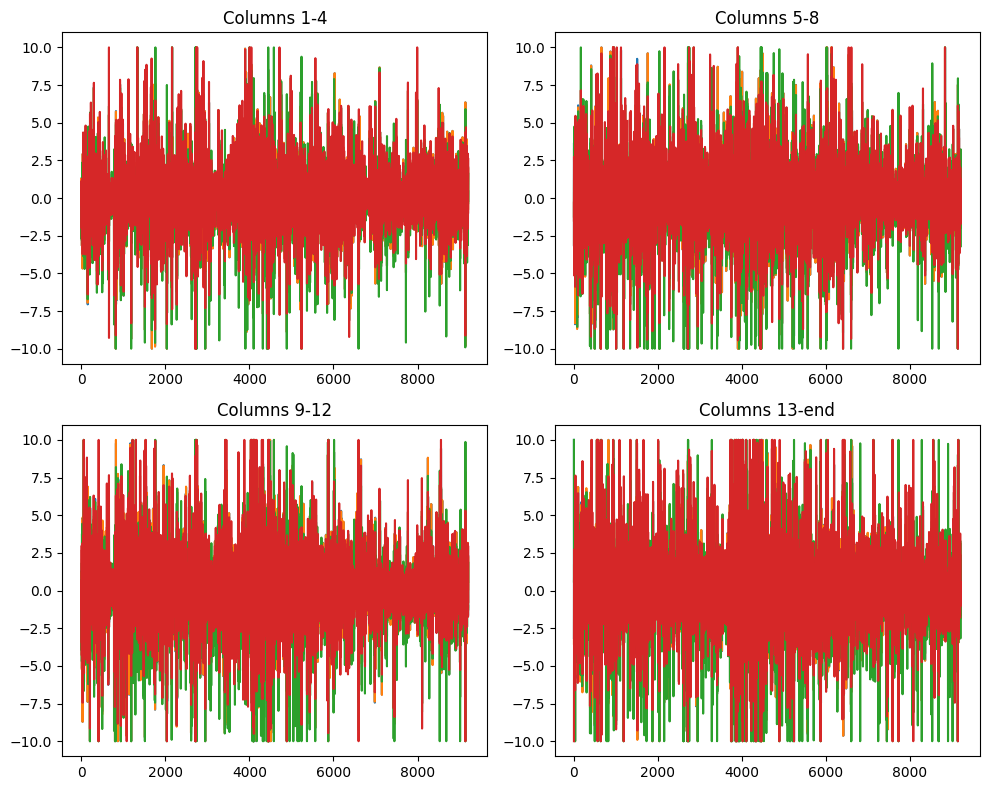

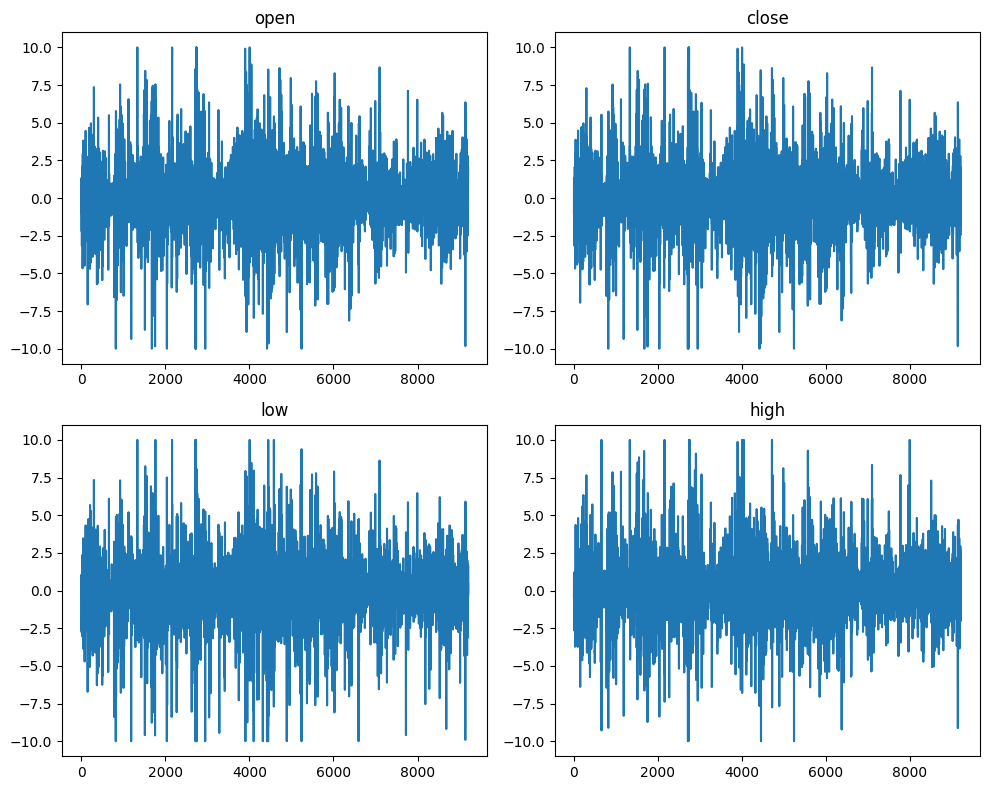

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(range(len(dataset_train.df)), dataset_train.df[dataset_train.df.columns[1:5]])
axes[0, 0].set_title('Columns 1-4')

axes[0, 1].plot(range(len(dataset_train.df)), dataset_train.df[dataset_train.df.columns[5:9]])
axes[0, 1].set_title('Columns 5-8')

axes[1, 0].plot(range(len(dataset_train.df)), dataset_train.df[dataset_train.df.columns[9:13]])
axes[1, 0].set_title('Columns 9-12')

axes[1, 1].plot(range(len(dataset_train.df)), dataset_train.df[dataset_train.df.columns[13:]])
axes[1, 1].set_title('Columns 13-end')

plt.tight_layout()

plt.show()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(range(len(dataset_train.df)), dataset_train.df[dataset_train.df.columns[1]])
axes[0, 0].set_title('open')

axes[0, 1].plot(range(len(dataset_train.df)), dataset_train.df[dataset_train.df.columns[2]])
axes[0, 1].set_title('close')

axes[1, 0].plot(range(len(dataset_train.df)), dataset_train.df[dataset_train.df.columns[3]])
axes[1, 0].set_title('low')

axes[1, 1].plot(range(len(dataset_train.df)), dataset_train.df[dataset_train.df.columns[4]])
axes[1, 1].set_title('high')

plt.tight_layout()

plt.show()

In [11]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset_val = LogReturnCoinDataset(csv_path="data/BTC_ETH_BNB_XRP_6h_log_returns_val.csv", coin_symbol="BTC",
                               input_window=28, output_window=8, augmentation_p=0, augmentation_noise_std=0,
                               augment_constant_c=0, augment_scale_s=0, distribution_scale=100, distribution_clip=distribution_clip)
train_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, drop_last=False)

dataset_val.df.describe()

,BTC_open,BTC_close,BTC_low,BTC_high,ETH_open,ETH_close,ETH_low,ETH_high,BNB_open,BNB_close,BNB_low,BNB_high,XRP_open,XRP_close,XRP_low,XRP_high
count,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000
mean,0.043476,0.044203,0.046246,0.043444,-0.033964,-0.033564,-0.027422,-0.036259,0.001995,0.002157,0.011375,0.000211,0.091771,0.091177,0.108769,0.083058
std,1.321790,1.321573,1.322307,1.245319,1.870245,1.870249,1.949620,1.698828,1.447976,1.448039,1.546906,1.332662,2.568246,2.567925,2.577156,2.367437
min,-6.324052,-6.324039,-10.000000,-5.426312,-10.000000,-10.000000,-10.000000,-9.669130,-9.212168,-9.210393,-10.000000,-7.398188,-10.000000,-10.000000,-10.000000,-8.933374
25%,-0.487572,-0.484406,-0.510878,-0.512986,-0.822526,-0.822927,-0.791998,-0.812234,-0.634018,-0.631341,-0.595928,-0.571876,-0.947101,-0.949549,-0.837206,-0.951038
50%,0.047558,0.047558,0.106440,-0.026694,0.035977,0.035977,0.122495,-0.077022,0.014946,0.017348,0.058991,-0.033417,0.100333,0.095770,0.158040,-0.132528
75%,0.644895,0.644900,0.635477,0.560855,0.878799,0.878940,0.881638,0.805392,0.737865,0.739230,0.693785,0.561366,1.053893,1.041960,1.052922,0.844353
max,8.871382,8.871381,8.249514,9.269290,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


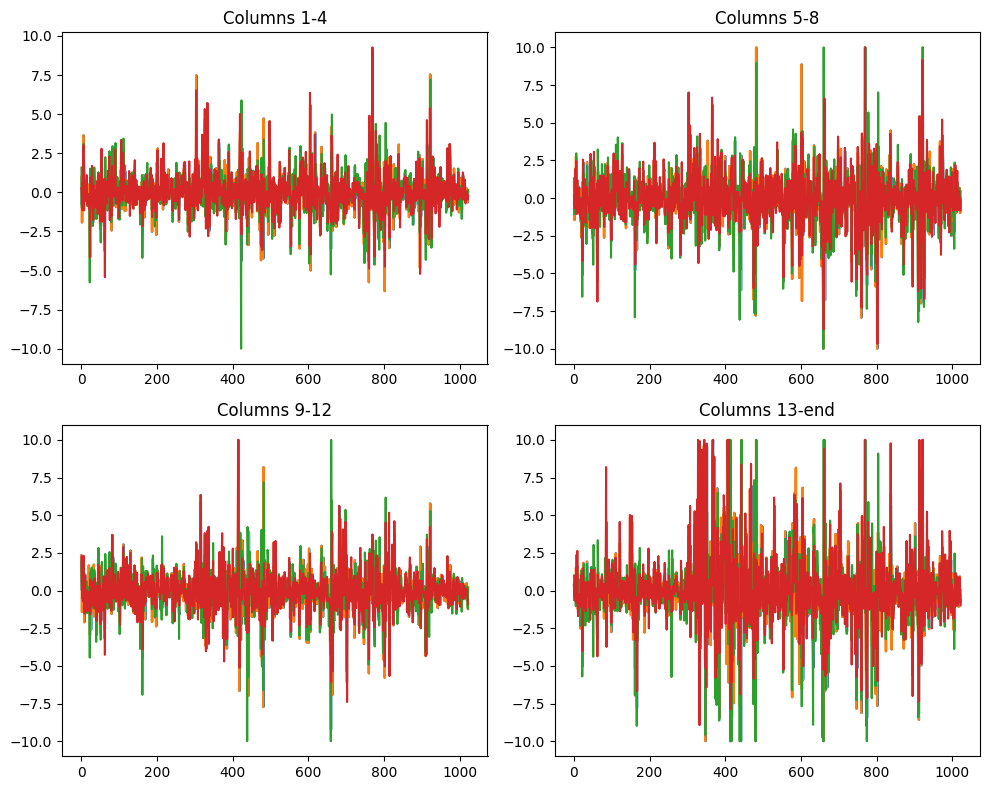

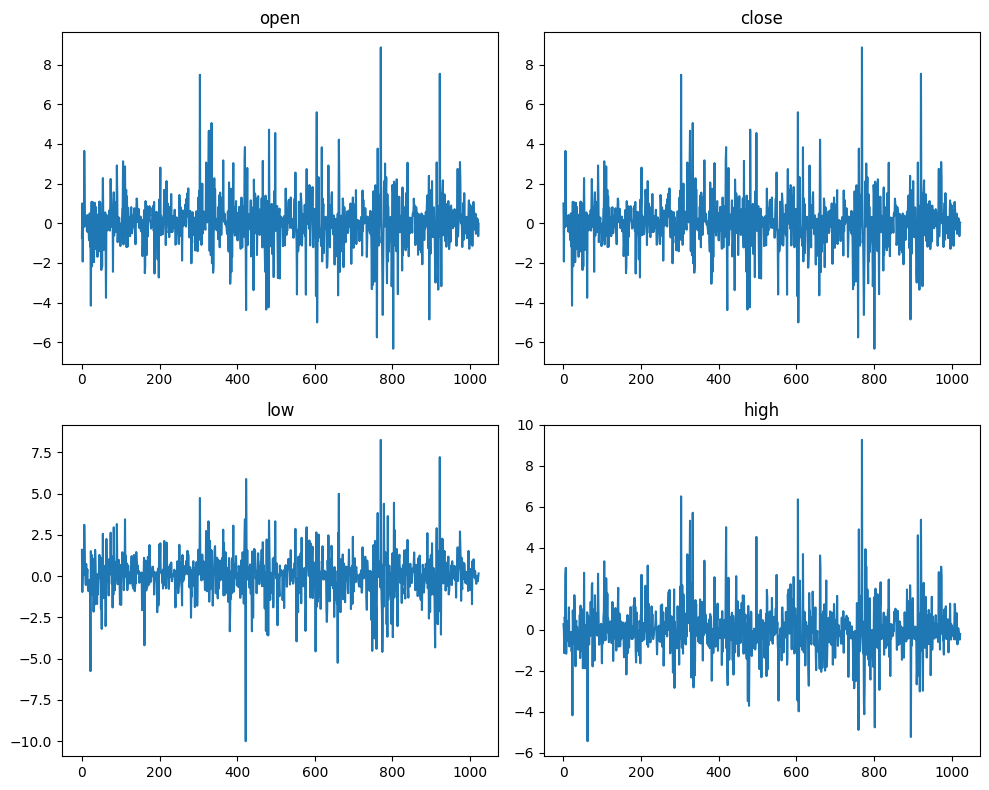

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(range(len(dataset_val.df)), dataset_val.df[dataset_val.df.columns[1:5]])
axes[0, 0].set_title('Columns 1-4')

axes[0, 1].plot(range(len(dataset_val.df)), dataset_val.df[dataset_val.df.columns[5:9]])
axes[0, 1].set_title('Columns 5-8')

axes[1, 0].plot(range(len(dataset_val.df)), dataset_val.df[dataset_val.df.columns[9:13]])
axes[1, 0].set_title('Columns 9-12')

axes[1, 1].plot(range(len(dataset_val.df)), dataset_val.df[dataset_val.df.columns[13:]])
axes[1, 1].set_title('Columns 13-end')

plt.tight_layout()

plt.show()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(range(len(dataset_val.df)), dataset_val.df[dataset_val.df.columns[1]])
axes[0, 0].set_title('open')

axes[0, 1].plot(range(len(dataset_val.df)), dataset_val.df[dataset_val.df.columns[2]])
axes[0, 1].set_title('close')

axes[1, 0].plot(range(len(dataset_val.df)), dataset_val.df[dataset_val.df.columns[3]])
axes[1, 0].set_title('low')

axes[1, 1].plot(range(len(dataset_val.df)), dataset_val.df[dataset_val.df.columns[4]])
axes[1, 1].set_title('high')

plt.tight_layout()

plt.show()